In [116]:
import pandas as pd
import numpy as np
from nltk.data import load
import sklearn
from sklearn import svm as SVM
from sklearn.model_selection import GridSearchCV
import nltk
import matplotlib.pyplot as plt
import helper
nltk.download('averaged_perceptron_tagger')
nltk.download('words')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/movieminer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/movieminer/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [117]:
data_path = 'A4data_2324_pan2020/'

def load_data():
    train_dataset = pd.read_csv(data_path + 'pan2324_train_data.csv')
    test_dataset = pd.read_csv(data_path + 'pan2324_test_data.csv')
    dev_dataset = pd.read_csv(data_path + 'pan2324_dev_data.csv')
    return train_dataset, test_dataset, dev_dataset

In [118]:
train_dataset, test_dataset, dev_dataset = load_data()

In [119]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
function_words = helper.function_words

def feature_extraction(dataset):
    text = dataset['text']
    authors = dataset['author']
    features = {}

    # Character based features
    features['CF'] = pd.DataFrame()
    features['LETTERS'] = pd.DataFrame()
    features['CHARS'] = pd.DataFrame()

    features['CF']['char_count'] = text.apply(len)
    uppercase_count = text.apply(lambda x: sum([1 for char in x if char.isupper()]))
    features['CF']['uppercase_frequency'] = uppercase_count / features['CF']['char_count']
    digit_count = text.apply(lambda x: sum([1 for char in x if char.isdigit()]))
    features['CF']['digit_frequency'] = digit_count / features['CF']['char_count']
    features['CF']['whitespace_frequency'] = text.apply(lambda x: sum([1 for char in x if char == ' '])) / features['CF']['char_count']
    alphabet_count = text.apply(lambda x: sum([1 for letter in set(x) if letter.isalpha()]))
    features['CF']['alphabet_frequency'] = alphabet_count / features['CF']['char_count']
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features['LETTERS'][letter + '_frequency'] = text.apply(lambda x: x.lower().count(letter))
    for special_character in ["~" , "@", "#", "$", "%", "^", "&", "*", "-", "_", "=" ,"+", ">", "<", "[", "]", "{", "}", "/", "\\", "|"]:
        features['CHARS'][special_character + '_frequency'] = text.apply(lambda x: x.count(special_character))

    # Word based features
    features['WF'] = pd.DataFrame()

    features['WF']['word_count'] = text.apply(lambda x: len(x.split()))
    features['WF']['avg_word_length'] = text.apply(lambda x: sum([len(word) for word in x.split()]) / len(x.split()))
    features['WF']['avg_sentence_length'] = text.apply(lambda x: sum([len(sentence) for sentence in x.split('.')]) / len(x.split('.')))
    features['WF']['avg_sentence_word_count'] = features['WF']['avg_sentence_length'] / features['WF']['avg_word_length']
    features['WF']['words_without_vowels'] = text.apply(lambda x: list(filter((lambda x: not any(v in x.lower() for v in ['a', 'e', 'u', 'o', 'i'])),x.split()))).apply(len)
    unique_words = text.apply(lambda x: len(set(x.split())))
    features['WF']['unique_words_frequency'] = unique_words / features['WF']['word_count']

    # Syntactic features
    features['PUNC'] = pd.DataFrame()
    features['FUNC'] = pd.DataFrame()

    punctuation_count = text.apply(lambda x: sum([1 for char in x if char in ['.', ',', ';', ':', '!', '?', "\'", "\""]]))
    features['PUNC']['punctuation_frequency'] = punctuation_count / features['CF']['char_count']
    
    for function_word in function_words:
        features['FUNC'][function_word + '_frequency'] = text.apply(lambda x: x.lower().count(function_word))

    # Structural features
    features['STRUCTF'] = pd.DataFrame()

    features['STRUCTF']['sentence_count'] = text.apply(lambda x: len(x.split('.')))
    features['STRUCTF']['repeated_punctuation_frequency'] = text.apply(lambda x: sum([1 for i in range(len(x)) if x[i] in ['.', ',', ';', ':', '!', '?', "\'", "\""] and x[i] == x[i-1]])) / features['CF']['char_count']

    # POS features
    features['POS'] = pd.DataFrame()

    pos = text.apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
    posfreq = pos.apply(lambda x: dict(nltk.FreqDist([tag for (word, tag) in x])))
    tags = list(tagdict)
    for i,tag in enumerate(tags):
        features['POS'][f'pos{i}'] = posfreq.apply(lambda x: x.get(tag, 0))


    return features, authors

In [120]:
def dict_to_df(dict):
    df = pd.DataFrame()
    for key in dict.keys():
        df = pd.concat([df, dict[key]], axis=1)
    return df


In [131]:
def train_model(X_train, y_train, X_dev, y_dev):
  X_train = dict_to_df(X_train)
  X_dev = dict_to_df(X_dev)
  # Append dev set to train set at the bottom
  
  X = pd.concat([X_train, X_dev], axis=0)
  y = pd.concat([y_train, y_dev], axis=0)

  X_train = sklearn.preprocessing.normalize(X_train)
  
  clf = SVM.SVC(random_state=42)
  params = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

  grid_search = GridSearchCV(clf, params, cv=5)
  grid_search.fit(X, y)
  
  best_clf = grid_search.best_estimator_
  best_score = grid_search.best_score_
  
  print(f'Best score: {best_score} with C={best_clf.C} and kernel={best_clf.kernel} and gamma={best_clf.gamma}')
  
  return best_clf, best_score

In [132]:
X_train, y_train = feature_extraction(train_dataset)
X_dev, y_dev  = feature_extraction(dev_dataset)
X_test, y_test = feature_extraction(test_dataset)

/tmp/ipykernel_13288/3232763261.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['FUNC'][function_word + '_frequency'] = text.apply(lambda x: x.lower().count(function_word))
/tmp/ipykernel_13288/3232763261.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['FUNC'][function_word + '_frequency'] = text.apply(lambda x: x.lower().count(function_word))
/tmp/ipykernel_13288/3232763261.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

In [133]:
model, accuracy = train_model(X_train, y_train, X_dev, y_dev)
print(accuracy)

Best score: 0.9414605455087285 with C=0.1 and kernel=linear and gamma=1
0.9414605455087285


In [134]:
def ablation_analysis(X_train, y_train, X_dev, y_dev, model):
  clf = model
  scores = []
  f = []

  X_train_df = dict_to_df(X_train)
  X_dev_df = dict_to_df(X_dev)

  clf.fit(X_train_df, y_train)
  scores.append(clf.score(X_dev_df, y_dev))
  f.append("None")

  for feature in X_train.keys():
    X_copy = X_train.copy()
    X_dev_copy = X_dev.copy()
    X_copy.pop(feature)
    X_dev_copy.pop(feature)

    X_train_ablated = dict_to_df(X_copy)
    X_dev_ablated = dict_to_df(X_dev_copy)


    clf.fit(X_train_ablated, y_train)
    scores.append(model.score(X_dev_ablated, y_dev))
    f.append(feature)

  # Reset model
  clf.fit(X_train_df, y_train)

  return f, scores


In [135]:
feature_names, scores = ablation_analysis(X_train, y_train, X_dev, y_dev, model)
print(feature_names)
print(scores)


['None', 'CF', 'LETTERS', 'CHARS', 'WF', 'PUNC', 'FUNC', 'STRUCTF', 'POS']
[0.9665271966527197, 0.9623430962343096, 0.9748953974895398, 0.9623430962343096, 0.9623430962343096, 0.9665271966527197, 0.9037656903765691, 0.9748953974895398, 0.9246861924686193]


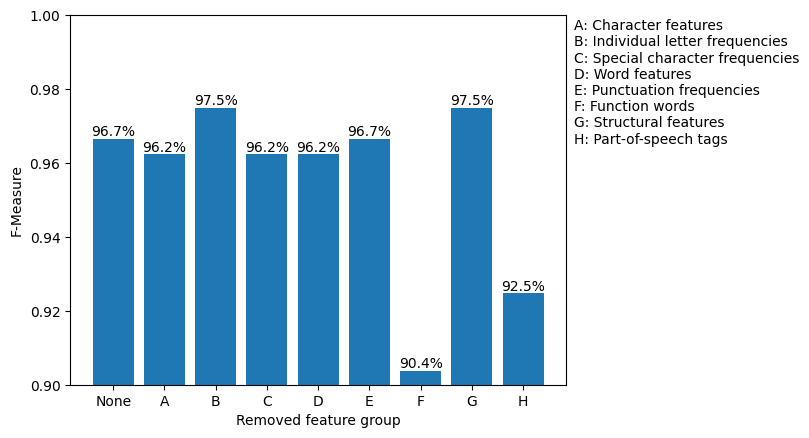

In [136]:
legend = ['A: Character features',
          'B: Individual letter frequencies', 
          'C: Special character frequencies',
          'D: Word features',
          'E: Punctuation frequencies',
          'F: Function words',
          'G: Structural features',
          'H: Part-of-speech tags']
legend = '\n'.join(legend)

fig, ax = plt.subplots()
bar_container = ax.bar(['None','A','B','C','D','E','F','G', 'H'], scores)
ax.set_ylim([0.9, 1])
ax.set_ylabel('F-Measure')
ax.set_xlabel('Removed feature group')
ax.bar_label(bar_container, fmt=lambda x: f'{x * 100:.1f}%')
plt.text(9,0.999, legend, va="top")

plt.show()

In [137]:

def test_accuracy(X_test, y_test, model):
  X_test_df = dict_to_df(X_test)
  return model.score(X_test_df, y_test)

print(test_accuracy(X_test, y_test, model))

0.9497907949790795
